# Using supervised learning to predict whether a customer subscribes to a scheme using data collected by the bank
## Samrat Chowdhury

## Introduction

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The data also consists of multiple attributes related to the client (age, job description, marital status, educational qualification, etc.), marketing details (number of contacts performed during this campaign and for this client, number of days that passed by after the client was last contacted from a previous campaign, etc.), social and economic context attributes (employment variation rate, consumer price index, consumer confidence index, etc.) and finally whether the client subscribes to the term deposit or not. Based on this data, we try to predict the customer response based on the given data.


## Methodology

We build three classifiers for this data set: a Decision tree, a Naïve Bayes classifier, and a Random forest classifier for this problem and choose a suitable metric to compare the performance of these models. An appropriate metric, in this case, would be "recall" **(type II error)**. Suppose a customer is classified as Yes but in reality. In that case, he/she is not interested in the term deposit, the bank can confirm from the customer again, but if a potential customer (who has high chances of subscribing) is classified as no, the bank won't reach out to him/her. It will run out of business very soon. So, from the bank's point of view, type II error is more severe in this case.

We tried to perform feature selection by calculating the Information Value (IV) score and multicollinearity. We dropped attributes having an IV score less than 0.2 or having high collinearity with some other attribute (greater than 0.9) to avoid overfitting. But we achieved significantly better results when the models were fitted using all the attributes except **'duration'** . This variable highly affects the output and the value of and also not known before a call. If we include this variable in the model, it introduces information leakage, which no doubt improves the model's performance, but it is not realistic to use this variable in modelling. To keep the model sensible, this attribute was dropped before performing any task. According to the documentation: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing# , this attribute should only be used for benchmark purposes). We also converted the variable **'pdays'** to categorical because 'number of days passed by after the client was last contacted from a previous campaign' has absolute discrete values, making more sense in a categorical setting.

It is important to note that there is a high imbalance in the data (88.3% No and 11.3% yes), so we may lose accuracy and precision while maximising Recall. Before proceeding further, we perform the train-test split (70-30 ratio) stratifying based on the outcome y (to account for the skewness in the data). This approach helps achieve realistic modelling since we use test data only during evolution and eclipse it from all the preprocessing steps. Without it, there is a chance of *information leakage* from test data. 

For Decision Tree and Random Forest, the following data-preprocessing is done:

> - Dummy encoding for all categorical variables except month, education and day of week
> - Label encoding month, education and day of week
> - Standard scaling all numerical variables

For Naïve Bayes Classifier, we have used Categorical Naïve Bayes, so the following data-preprocessing is done:

> - Ordinal Encoding all categorical variables (including month, education and day of the week)
> - Discretising all numerical variables by binning them individually (heuristically finding the number of bins for each variable) and assigning them to categories. Finally, encoding them ordinally to obtain numerical inputs for the model. 

For **Decision Tree**, we pass 'balanced' to the argument class_weight to account for the skewness in the data. To avoid overfitting and to obtain the best results, we do hyperparameter tuning using RandomizedSearch. The best parameters are: *max_depth: 8*, *max_leaf_nodes: 40* and *min_samples_leaf: 12*. We used *CategoricalNB* for **Naïve Bayes** because that gave us the best results (we also tried GaussianNB, MultinomialNB). For **Random Forest**, we use **Balanced Random Forest** to avoid the cost of imbalance in modelling and again do hyperparameter-tuning using RandomizedSearch. The best parameters obtained are *max_depth: 8*, *max_leaf_nodes: 49*, *min_samples_leaf: 13*

The precision of a model is given by $$ Precision = \dfrac{\text{TP}}{\text{TP}+\text{FP}}$$ and the Recall is given by $$ Recall = \dfrac{\text{TP}}{\text{TP}+\text{FN}}$$, so there will be an apparent trade-off between Precision and Recall, and although Recall is the suitable metric for this problem, pushing the Recall to an exceptionally high value (and pulling down the precision) kills the purpose of building a model. So we want to achieve an optimum level where these metrics reach a suitable value. To tackle this, we employ two diagnostics, plotting the precision-recall (PR) curve and the receiver operating characteristic (ROC) curve and trying to maximise the ROC-AUC (area under the curve) score, which justifies the cost of losing accuracy-score for maximising Recall. Finally, we have used **Balanced Bagging Classifier ** for each classifier to aggregate the results obtained from multiple classifiers because *'wisdom of the crowd'* gives us a better result.

|     Model     | Precision |  Recall | F1-score | Accuracy | PR-AUC | ROC-AUC |
|:-------------:|:---------:|:-------:|:--------:|:--------:|:------:|:-------:|
| Baseline Model |  0.118168  | 0.114943 |  0.116533 |  0.803674 |  0.556 |  0.5  |  244 µs   | 0.00 MiB |
| Decision Tree |  0.399911  | 0.644397 |  0.493535 |  0.851016 |  0.49 |  0.813  |   1min    | 14.71 MiB |
|  Naïve Bayes  |  0.387065  | 0.558908 |  0.457378 |  0.850611 |  0.43 |  0.786  |   42.8 s   | 0.09 MiB |
| Random Forest |  0.383929  | 0.648707 | 0.482372 |  0.843166 |  0.477 |  0.809  |   49.7 s   | 0.02 MiB |

Here Memory Usage represents the increment in the memory after calling the training procedure of the given machine learning model. Here Time and Memory Usage are subject to change on every run because of factors like temporal caching, spatial caching, etc.

# Packages & Data Loading

In [4]:
import pandas as pd
import numpy as np
import psutil, os, time
from scipy.stats import randint, uniform

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics as me
from sklearn import tree, decomposition
from sklearn import ensemble as en
import sklearn.naive_bayes as nb

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

seed = 42            # setting random seed
np.random.seed(seed)

In [5]:
data = pd.read_csv('Data/bank-additional-full.csv', sep=';', header=0)
data['pdays'] = data['pdays'].astype('category')
data.drop(['duration'], axis=1, inplace=True)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Checking for missing values

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  object  
 2   marital         41188 non-null  object  
 3   education       41188 non-null  object  
 4   default         41188 non-null  object  
 5   housing         41188 non-null  object  
 6   loan            41188 non-null  object  
 7   contact         41188 non-null  object  
 8   month           41188 non-null  object  
 9   day_of_week     41188 non-null  object  
 10  campaign        41188 non-null  int64   
 11  pdays           41188 non-null  category
 12  previous        41188 non-null  int64   
 13  poutcome        41188 non-null  object  
 14  emp.var.rate    41188 non-null  float64 
 15  cons.price.idx  41188 non-null  float64 
 16  cons.conf.idx   41188 non-null  float64 
 17  euribor3m   

Encoding y by setting 1 to 'yes' and 0 to 'no' and dropping the 'duration' attribute (read the documentation of the data)

We also convert **pdays** to a categorical variable

Note that there is a high imbalance in the data

In [7]:
# The baseline accuracy is 88.7% if we predict yes for all inputs.
# It shows imbalance in data.

{"YES": round(np.mean(data["y"] == "yes"), 3), "NO": np.round(np.mean(data["y"] == "no"), 3)}

{'YES': 0.113, 'NO': 0.887}

In [7]:
# Selecting the Categorical attributes
catvar = data.select_dtypes(include=['object','category']).astype('category').columns.values.tolist()
catvar = [i for i in catvar if i not in ['month','education','day_of_week','y']]

# Selecting the Numeric Variables
numvar = data._get_numeric_data().columns.values.tolist()

In [8]:
# Splitting Data before any sort of prepocessing to avoid any form of data leakage.

X = data.loc[:, data.columns != "y"]
Y = data[["y"]]

_x_train, _x_test, _y_train, _y_test = train_test_split(X, Y, test_size=0.30, random_state=seed, stratify=Y)

# Pre-Processing

In [9]:
# Preprocessors fitted with train data

class DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, min_frequency=1, dummy_na=True):
        self.min_frequency = min_frequency
        self.dummy_na = dummy_na
        self.categories = dict()
        self.features = []

    def fit(self, X):
        for col in X.columns:
            counts = pd.value_counts(X[col])
            self.categories[col] = list(set(counts[counts >= self.min_frequency].index.tolist()))
        return self

    def transform(self, X, *_):
        for col in X.columns:
            X = X.astype({col: CategoricalDtype(self.categories[col], ordered=True)})
        ret = pd.get_dummies(X, dummy_na=self.dummy_na)
        self.features = ret.columns
        return ret

    def get_feature_names(self):
        return self.features
    

dum_proc = DummyEncoder().fit(_x_train[catvar])
num_proc = StandardScaler().fit(_x_train[numvar])
le_dict = {col: LabelEncoder().fit(_x_train[col]) for col in ['month','education','day_of_week']}
out_proc = lambda x: x.replace({"no": 0, "yes": 1}).values
ord_proc= OrdinalEncoder().fit(_x_train[catvar+['month','education','day_of_week']])

In [10]:
# Data Processing for Decsion Tree and Random Forest

def pre_processing(data):
    temp1=data[catvar]
    temp2=data[['month','education','day_of_week']]
    temp3=data[numvar]
    temp1[dum_proc.get_feature_names()]=dum_proc.transform(temp1)
    temp1.drop(catvar,axis=1,inplace=True)
    for col in ['month','education','day_of_week']:
        temp2[col]=le_dict[col].transform(temp2[col])
    temp3[temp3.columns] = num_proc.transform(temp3[temp3.columns])
    return pd.concat([temp1,temp2,temp3],axis=1)

In [11]:
# Data Processing for Naive Bayes

def pre_processing_naive_bayes(data,retain,bi=[],ord_enc=None):
    temp2=data[catvar+['month','education','day_of_week']]
    temp3=data[numvar]
    temp2[temp2.columns]=ord_proc.transform(temp2[temp2.columns])
    temp3[temp3.columns] = num_proc.transform(temp3[temp3.columns])
    col=temp3.columns.values.tolist()
    if retain==True:
        bi=[]
        for i in temp3.columns:
            for j in range(5,0,-1):
                try:
                    temp,b=pd.qcut(temp3[i],j,labels=['Category '+str(k) for k in range(1,j+1)],retbins=True)
                except:
                    continue
                else:
                    temp3[str(i)+'_qt']=temp
                    b=np.concatenate(([-np.inf],b[1:-1],[np.inf]))
                    bi.append(b)
                    break
    else:
        for i in range(len(col)):
            temp3[str(col[i])+'_qt']=pd.cut(temp3[col[i]],bins=bi[i],include_lowest = True,labels=['Category '+str(k) for k in range(1,len(bi[i]))])
    temp3=temp3.select_dtypes(include=['object','category']).astype('category')
    if retain==True:
        ord_enc=OrdinalEncoder().fit(temp3[temp3.columns])
    temp3[temp3.columns]=ord_enc.transform(temp3[temp3.columns])
    return(pd.concat([temp3,temp2],axis=1),bi,ord_enc)

In [12]:
# Transform Train Variables
X_train = pre_processing(_x_train)
y_train = out_proc(_y_train)

# Transform Test Variables
X_test = pre_processing(_x_test)
y_test = out_proc(_y_test)

# Transform X Varaible for Naive Bayes
X_train_nb,bins,ord_enc = pre_processing_naive_bayes( _x_train,True)
X_test_nb = pre_processing_naive_bayes( _x_test,False,bins,ord_enc)[0]

# Visualization and Utility Functions

In [13]:
# Function to Plot Precision-Recall Curve

def plot_pr_curve(y_test, model_probs, name, ax):
    precision, recall, _ = me.precision_recall_curve(y_test, model_probs)
    
    ax.plot(recall, precision, marker='.', label=name)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title("PR Curve for {}".format(name))
    ax.legend()

    return ax

In [14]:
# Function to plot ROC Curve

def plot_roc_curve(y_test, model_probs,name, ax): 
    fpr, tpr, _ = me.roc_curve(y_test, model_probs)

    ax.plot(fpr, tpr, marker='.', label=name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title("PR Curve for {}".format(name))
    ax.legend()

    return ax

In [15]:
# Function to Plot Confusion Matrix

def plot_conf_matrix(y_pred, y_test, ax, normalize="true"):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    cf_mat = me.confusion_matrix(y_test, y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in cf_mat.flatten()]
    cf_mat = me.confusion_matrix(y_test, y_pred, normalize=normalize)
    group_percentages = ['{0:.2%}'.format(value) for value in cf_mat.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_mat, annot=labels, fmt='', cmap='RdPu', ax=ax)
    ax.set_title('Confusion Matrix [{} Normalized]'.format(normalize.capitalize()))
    ax.set_ylabel("True Class")
    ax.set_xlabel("Predicted Class")
    return ax

In [16]:
# Evaluation of Mode with Several Metrics

def result_disp(model, X_train, X_test, y_train, y_test, name):
    y_pred = model.predict(X_train)
    print('\nTraining Data Scores:')
    print('Precision: {:0.6f}'.format(me.precision_score(y_train, y_pred)))
    print('Recall: {:0.6f}'.format(me.recall_score(y_train, y_pred)))
    print('F-Score: {:0.6f}'.format(me.f1_score(y_train, y_pred)))
    print('Accuracy: {:0.6f}'.format(me.accuracy_score(y_train, y_pred)))
    
    y_pred = model.predict(X_test)
    print('\nTest Data Scores:')
    print('Precision: {:0.6f}'.format(me.precision_score(y_test, y_pred)))
    print('Recall: {:0.6f}'.format(me.recall_score(y_test, y_pred)))
    print('F-Score: {:0.6f}'.format(me.f1_score(y_test, y_pred)))
    print('Accuracy: {:0.6f}\n\n'.format(me.accuracy_score(y_test, y_pred)))
    
    # Calculate Posterior Probs
    yhat = model.predict_proba(X_test)
    model_probs = yhat[:, 1]
    
    # Figure Generation for Subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    # Calculate the Precision-Recall AUC
    precision, recall, _ = me.precision_recall_curve(y_test, model_probs)
    auc_score = me.auc(recall, precision)
  
    ax[0, 0] = plot_pr_curve(y_test, model_probs, name, ax[0, 0])
    ax[0, 0].axvline(x = me.recall_score(y_test,y_pred), linestyle='--', c='r')
    ax[0, 0].axhline(y = me.precision_score(y_test,y_pred), linestyle='--', c='r')
    ax[0, 0].set_title('PR AUC: {}'.format(np.round(auc_score,3)), fontsize=12)

    # Calculate the ROC Area Under Curve
    roc_auc = me.roc_auc_score(y_test, model_probs)
    
    ax[0, 1] = plot_roc_curve(y_test, model_probs, name, ax=ax[0, 1])
    ax[0, 1].set_title('ROC AUC {}'.format(np.round(roc_auc,3)),fontsize=12)
    
    # Plotting Confusion Matrix with Truth axis normalized.
    ax[1, 0] = plot_conf_matrix(y_pred, y_test, ax=ax[1, 0], normalize="true")

    # Plotting Confusion Matrix with Prediction axis normalized.
    ax[1, 1] = plot_conf_matrix(y_pred, y_test, ax=ax[1, 1], normalize="pred")

    fig.suptitle('Result for {} on Test Data'.format(name), fontsize=18)
    plt.show()

# Baseline Model

In this case we are predicting same class for all examples of test data on the basis of distribution of **Yes** and **No** in train dataset.

In [17]:
class Baseline:
    def __init__(self):
        self.class_prob = np.array([1-y_train.mean(), y_train.mean()]).reshape(1, -1)
    
    def predict(self, data):
        return np.random.choice([0, 1], size=(data.shape[0],1), p = self.class_prob.ravel(), )

    def predict_proba(self, data):
        return np.repeat(self.class_prob, data.shape[0], axis=0)

In [18]:
# Model Instantiation [Time Profiling]

clf = Baseline()

CPU times: user 244 µs, sys: 60 µs, total: 304 µs
Wall time: 232 µs


In [19]:
# Model Instantiation [Memory Profiling]

clf = Baseline()

peak memory: 917.97 MiB, increment: -28.22 MiB



Training Data Scores:
Precision: 0.115751
Recall: 0.116071
F-Score: 0.115911
Accuracy: 0.800527

Test Data Scores:
Precision: 0.107725
Recall: 0.109195
F-Score: 0.108455
Accuracy: 0.797766




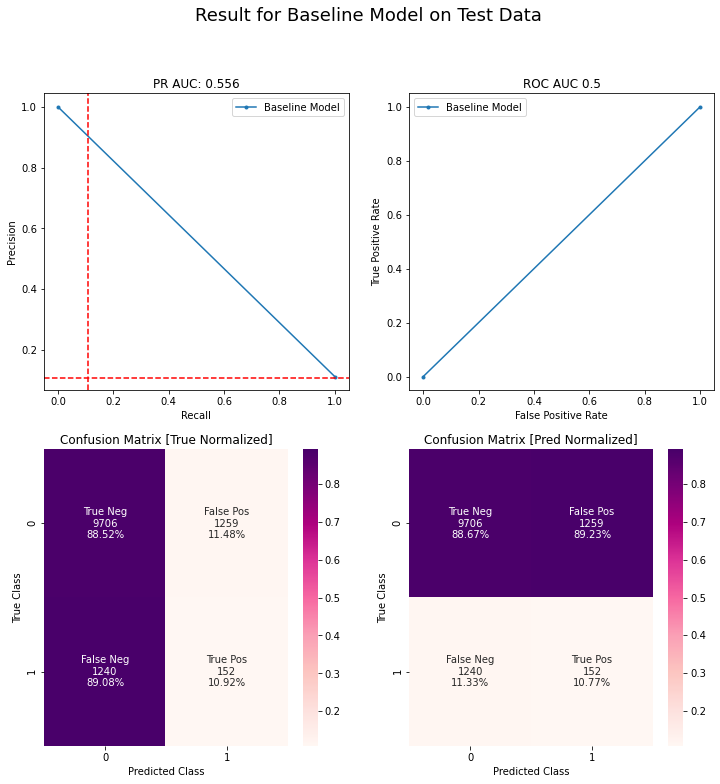

In [20]:
# Final Results

result_disp(clf, X_train, X_test, y_train, y_test, 'Baseline Model')

# Decision Tree

In [21]:
# Base Classifier

dec_tree = tree.DecisionTreeClassifier(class_weight = 'balanced')
bg_clf = BalancedBaggingClassifier(base_estimator = dec_tree, 
                                   oob_score = True, 
                                   random_state = seed)

In [22]:
# Randomized Parameter Searching [Time and Memory Profiling]

clf_gs = RandomizedSearchCV(bg_clf, 
                            {
                                'n_estimators': randint(40,44),
                                'base_estimator__max_depth': randint(2,10), 
                                'base_estimator__max_leaf_nodes':randint(30,50),
                                'base_estimator__min_samples_leaf':randint(5,15)
                            }, 
                            scoring = 'roc_auc', 
                            random_state=seed)

clf_gs.fit(X_train,y_train);

peak memory: 1615.92 MiB, increment: 663.73 MiB
CPU times: user 1min, sys: 281 ms, total: 1min
Wall time: 1min


In [23]:
# Best Parameters

clf_gs.best_params_

{'base_estimator__max_depth': 8,
 'base_estimator__max_leaf_nodes': 49,
 'base_estimator__min_samples_leaf': 13,
 'n_estimators': 42}


Training Data Scores:
Precision: 0.384515
Recall: 0.637623
F-Score: 0.479731
Accuracy: 0.844195

Test Data Scores:
Precision: 0.393059
Recall: 0.650862
F-Score: 0.490127
Accuracy: 0.847455




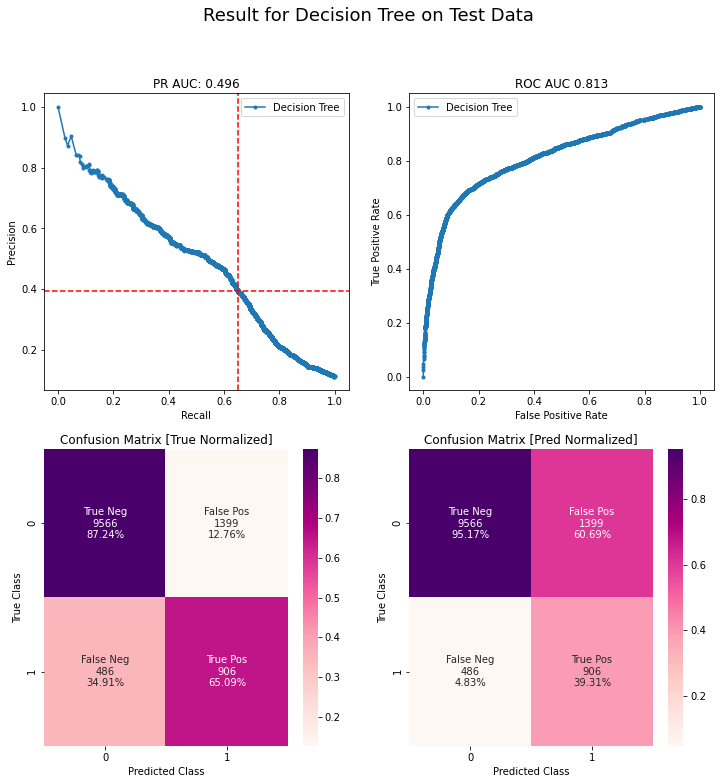

In [24]:
# Final Results

result_disp(clf_gs, X_train, X_test, y_train, y_test, 'Decision Tree')

# Naive Bayes

Here we ahve implemented Categeorical Naive Bayes. To implement this method we have converted all numerical variables to categorical variables. Finally we have perfomed Bagging over it.

In [25]:
# Base Estimator

nb_clf = nb.CategoricalNB()
bg_clf = en.BaggingClassifier(base_estimator=nb_clf, 
                              oob_score=True, 
                              random_state=seed)

In [26]:
# Randomized Parameter Searching [Time and Memory Profiling]

clf_gs = RandomizedSearchCV(bg_clf,
                            {
                                'n_estimators': randint(35,55)
                            }, 
                            scoring = 'roc_auc',
                            random_state = seed)

clf_gs.fit(X_train_nb, y_train);

peak memory: 1690.45 MiB, increment: 0.00 MiB
CPU times: user 42.5 s, sys: 181 ms, total: 42.6 s
Wall time: 42.8 s


In [27]:
# Best Parameters

clf_gs.best_params_

{'n_estimators': 42}


Training Data Scores:
Precision: 0.365652
Recall: 0.543411
F-Score: 0.437152
Accuracy: 0.842357

Test Data Scores:
Precision: 0.387065
Recall: 0.558908
F-Score: 0.457378
Accuracy: 0.850611




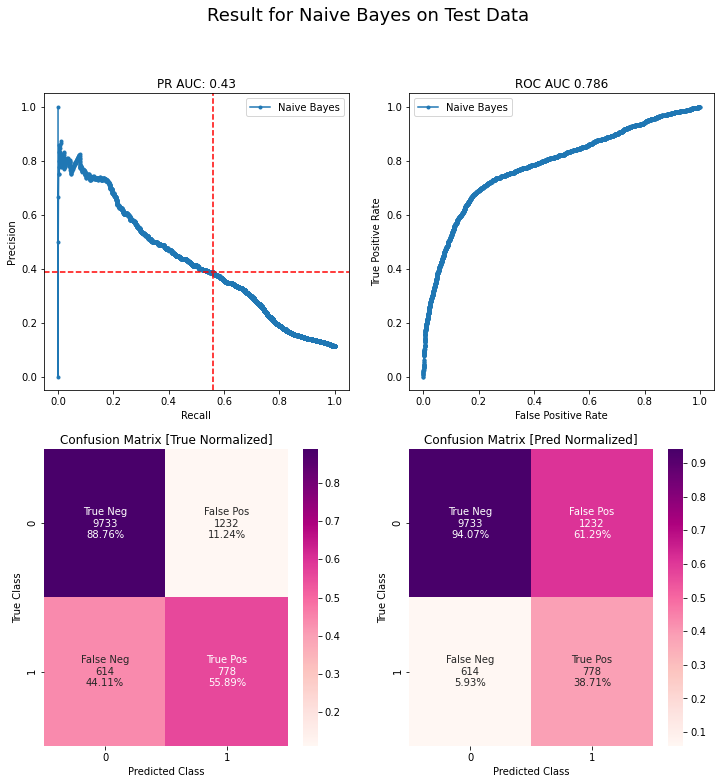

In [28]:
# Final Results

result_disp(clf_gs, X_train_nb, X_test_nb, y_train, y_test, 'Naive Bayes')

# Random Forest

In [29]:
# Base Estimator

rf_clf = BalancedRandomForestClassifier(random_state = seed)

In [30]:
# Randomized Parameter Searching [Time and Memory Profiling]

clf_gs = RandomizedSearchCV(rf_clf,
                            {
                                'n_estimators': randint(100,150),
                                'max_depth': randint(2,10), 
                                'max_leaf_nodes':randint(30,50),
                                'min_samples_leaf':randint(5,15)
                            }, 
                            scoring = 'roc_auc',
                            random_state = seed)

clf_gs.fit(X_train, y_train);

peak memory: 1695.12 MiB, increment: 0.00 MiB
CPU times: user 49.2 s, sys: 366 ms, total: 49.6 s
Wall time: 49.7 s


In [31]:
# Best Parameters

clf_gs.best_params_

{'max_depth': 8,
 'max_leaf_nodes': 48,
 'min_samples_leaf': 11,
 'n_estimators': 110}


Training Data Scores:
Precision: 0.345768
Recall: 0.647783
F-Score: 0.450873
Accuracy: 0.822240

Test Data Scores:
Precision: 0.349028
Recall: 0.670977
F-Score: 0.459194
Accuracy: 0.821963




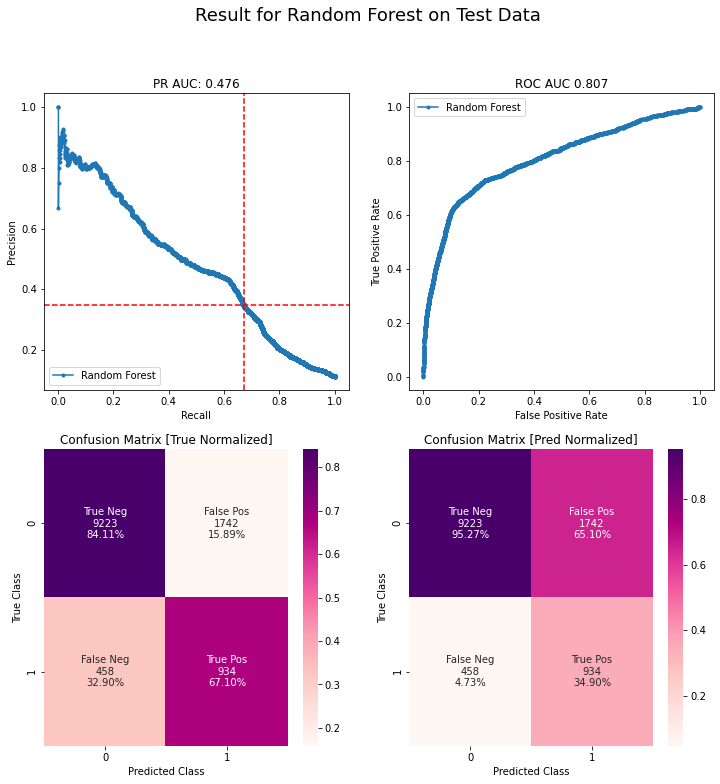

In [32]:
# Final Results

result_disp(clf_gs, X_train, X_test, y_train, y_test, 'Random Forest')